### Install library and load img

In [ ]:
import requests
import matplotlib.pylab as plt
import time
import matplotlib.image as mpimg
from PIL import Image, ImageSequence
import io
import numpy as np
img_url = [
           'https://i.imgur.com/y2Dh8Ef.jpg', # bk h6
            'https://i.imgur.com/NHFw7G8.jpg',  # tv in elevator
           'https://i.imgur.com/TaUu9ZC.png',  # poster
]

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
response = [requests.get(i, stream=True, headers=headers) for i in img_url]
# Check for successful download
img_list = []
for r in response:
    if r.headers['Content-Type'] == 'image/gif':
        img = Image.open(io.BytesIO(r.content))
        frames = [frame.copy() for frame in ImageSequence.Iterator(img)]
        img_list.append(frames[0])  # Only take the first frame of the GIF
    else:
        img = Image.open(io.BytesIO(r.content))

        img_list.append(img)

In [ ]:
def show_img(img):
  plt.figure(figsize=(10, 10))
  plt.plot(221), plt.imshow(img), plt.title('Image')
  plt.show()

def print_two_images(image1, image2, name1, name2):
  fig = plt.figure(figsize=(10, 7))
  ax1 = fig.add_subplot(1, 2, 1)
  ax1.imshow(image1)
  ax1.set_title(name1)
  ax2 = fig.add_subplot(1, 2, 2)
  ax2.imshow(image2)
  ax2.set_title(name2)
  plt.show()

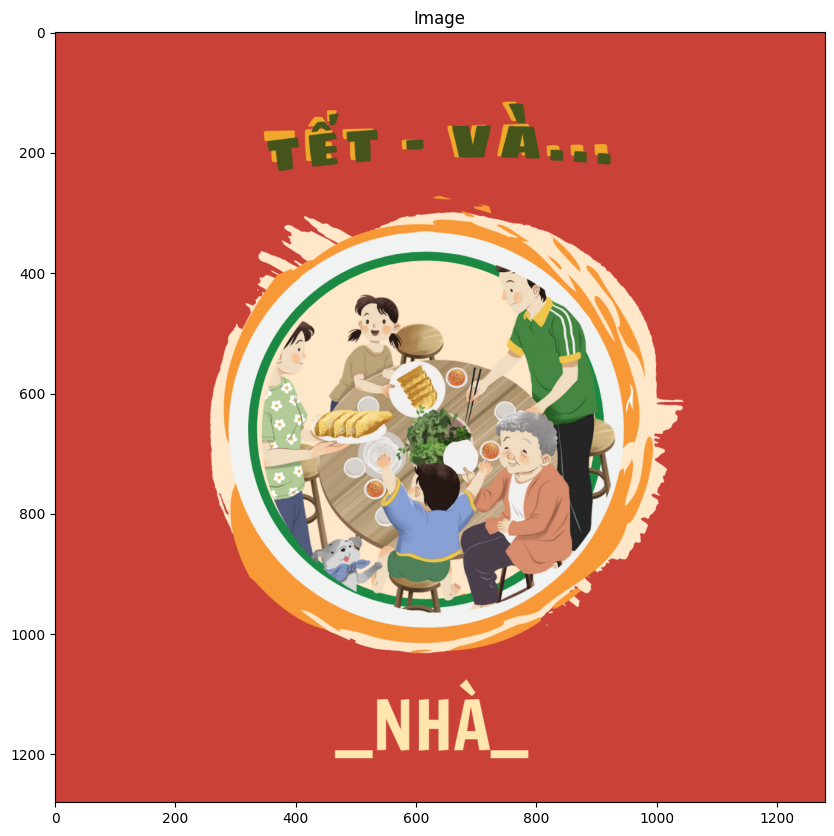

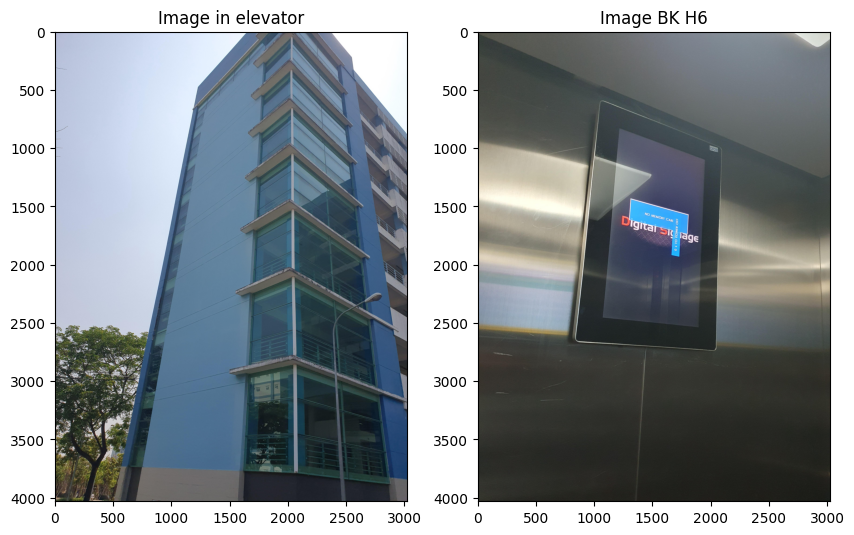

In [ ]:
show_img(img_list[2])
print_two_images(img_list[0], img_list[1], "Image in elevator", "Image BK H6")

### Define Transform function

In [ ]:
import numpy as np

def transform_image(img, transformation_matrix):
    # Convert image to numpy array
    img = np.array(img)
    # Get image dimensions
    height, width, _ = img.shape

    # Define corner points of the image
    top_left = np.array([[0, 0, 1]], dtype='double').reshape(3, 1)
    top_right = np.array([0, width-1, 1], dtype='double').reshape(3, 1)
    bottom_left = np.array([[height-1, 0, 1]], dtype='double').reshape(3, 1)
    bottom_right = np.array([[height-1, width-1, 1]], dtype='double').reshape(3, 1)

    # Apply transformation to corner points
    new_top_left = transformation_matrix.dot(top_left)
    new_top_left = (new_top_left / new_top_left[2]).astype("int64")
    new_top_right = transformation_matrix.dot(top_right)
    new_top_right = (new_top_right / new_top_right[2]).astype("int64")
    new_bottom_left = transformation_matrix.dot(bottom_left)
    new_bottom_left = (new_bottom_left / new_bottom_left[2]).astype("int64")
    new_bottom_right = transformation_matrix.dot(bottom_right)
    new_bottom_right = (new_bottom_right / new_bottom_right[2]).astype("int64")

    # Calculate dimensions of the transformed image
    new_top = np.max([new_top_left[0], new_top_right[0], new_bottom_left[0], new_bottom_right[0]]) + 1
    new_bottom = np.min([new_top_left[0], new_top_right[0], new_bottom_left[0], new_bottom_right[0]]) - 1
    new_right = np.max([new_top_left[1], new_top_right[1], new_bottom_left[1], new_bottom_right[1]]) + 1
    new_left = np.min([new_top_left[1], new_top_right[1], new_bottom_left[1], new_bottom_right[1]]) - 1

    # Handle cases where new dimensions are negative
    if new_bottom < 0:
        if new_top < 0:
            new_height = -new_bottom + 1
        else:
            new_height = new_top - new_bottom + 1
    else:
        new_height = new_top + 1

    if new_left < 0:
        if new_right < 0:
            new_width = -new_left + 1
        else:
            new_width = new_right - new_left + 1
    else:
        new_width = new_right + 1

    # Create array for transformed image
    new_img = np.zeros((new_height, new_width, 3), dtype=img.dtype)

    # Get the inverse of the transformation matrix
    transformation_matrix_inverse = np.linalg.inv(transformation_matrix)

    # Iterate through each pixel in the transformed image
    for i in range(new_height):
        for j in range(new_width):
            new_position = np.array([[i, j, 1]]).reshape(3, 1)
            if new_bottom < 0:
                new_position[0, 0] += new_bottom
            if new_left < 0:
                new_position[1, 0] += new_left
            position = transformation_matrix_inverse.dot(new_position).reshape(3)
            if abs(position[2]) > 0.00001:
                position = position / position[2]
            if 0 <= position[0] < height and 0 <= position[1] < width:
                new_img[i, j] = img[int(position[0]), int(position[1])]

    return new_img


## Affine

#### a) Translation


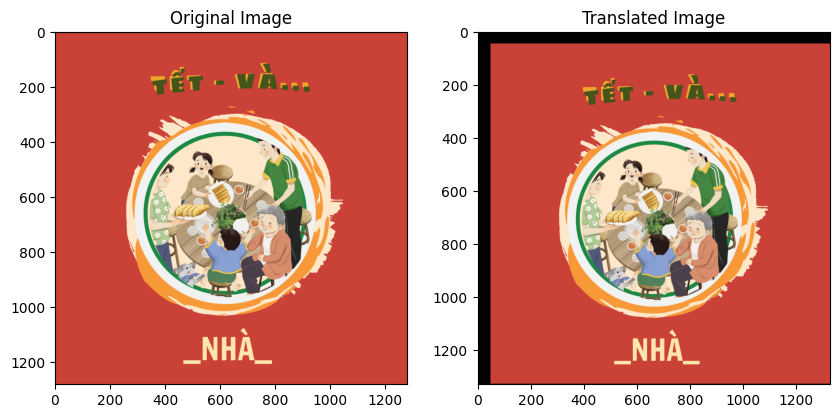

In [ ]:
translation_kernel = np.array([[1, 0, 47],
                               [0, 1, 47],
                               [0, 0, 1]])
translated_image = transform_image(img_list[2], translation_kernel)
print_two_images(img_list[2], translated_image, "Original Image", "Translated Image")

#### b) Rotation

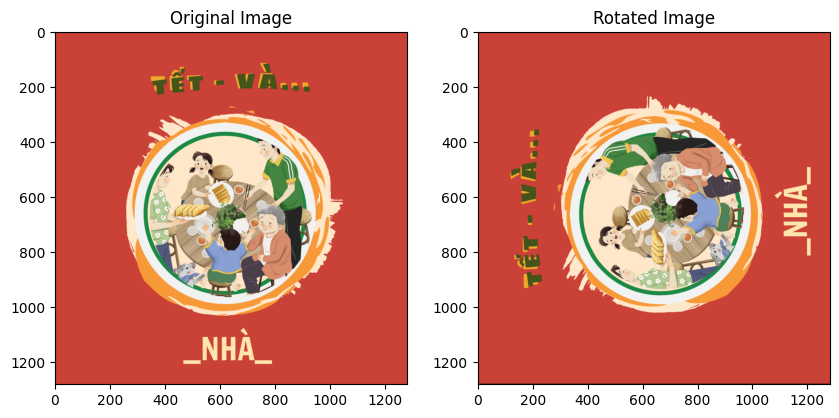

In [ ]:
def rotation_matrix(angle):
    cos_theta = np.cos(angle)
    sin_theta = np.sin(angle)
    return np.array([[cos_theta, -sin_theta, 0],
                     [sin_theta, cos_theta, 0],
                     [0, 0, 1]])

angle_rad = np.deg2rad(90)
rotation_kernel = rotation_matrix(angle_rad)
rotation_image = transform_image(img_list[2], rotation_kernel)
print_two_images(img_list[2], rotation_image, "Original Image", "Rotated Image")

#### c) Scale

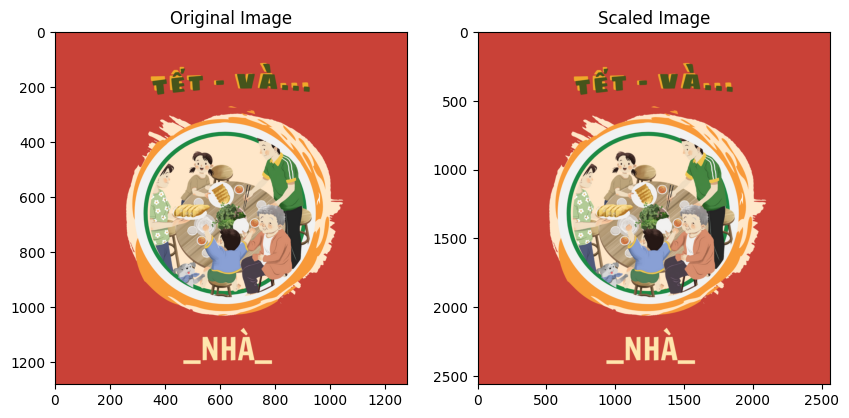

In [ ]:
scale_kernel = np.array([[2, 0, 0],
                         [0, 2, 0],
                         [0, 0, 1]])

scaled_image = transform_image(img_list[2], scale_kernel)
print_two_images(img_list[2], scaled_image, "Original Image", "Scaled Image")

#### d) Shear

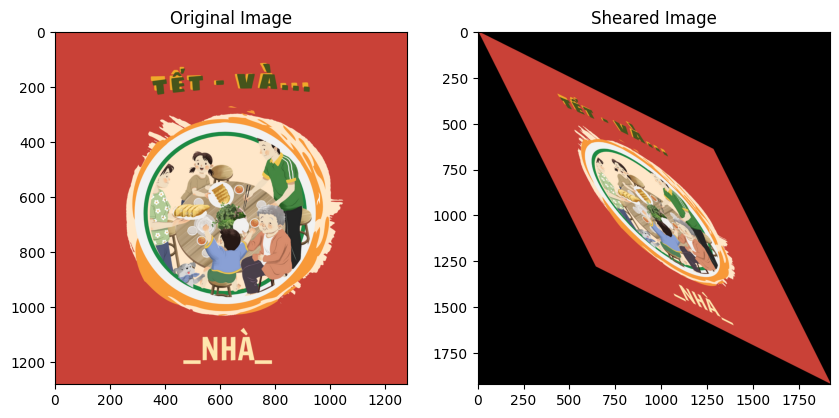

In [ ]:
Shear_Matrix = np.array([[1, 0.5, 0],
                        [0.5, 1, 0],
                        [0, 0, 1]])
shear_foreground_image = transform_image(img_list[2], Shear_Matrix)
print_two_images(img_list[2], shear_foreground_image, "Original Image", "Sheared Image")

#### e) Perspective

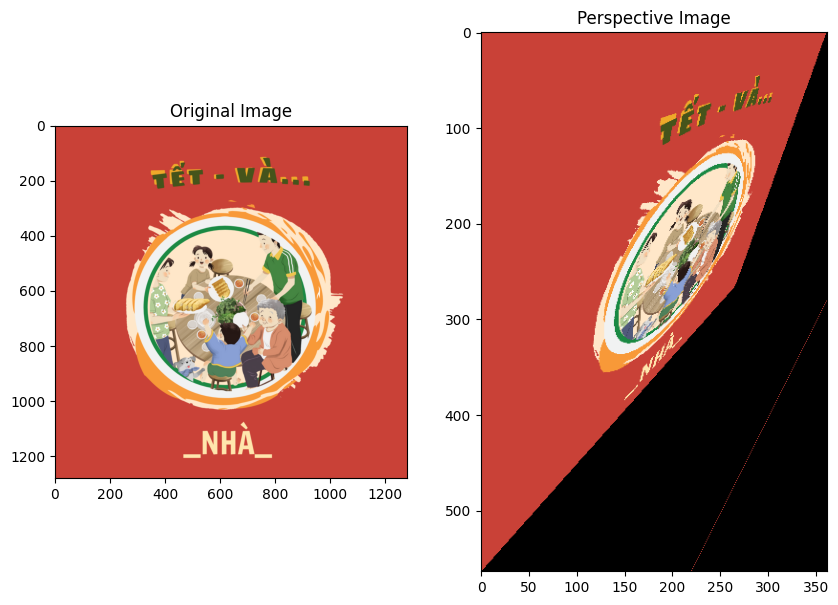

In [ ]:
perspective_kernel = np.array([[1, 0, 0],
                              [0, 1, 0],
                              [0.001, 0.002, 1]])
perspective_foreground_image = transform_image(img_list[2], perspective_kernel)
print_two_images(img_list[2], perspective_foreground_image, "Original Image", "Perspective Image")

## Projective

In [ ]:
def warp_and_combine(poster_img, background_img, anchor_lst):
    # Convert images to numpy arrays
    poster_img = np.array(poster_img)
    background_img = np.array(background_img)

    # Get the shape of the foreground image
    height, width, _ = poster_img.shape

    # Define the coordinates of the corners of the poster image
    origin_lst = np.array([(0, 0), (height-1, 0), (height-1, width-1), (0, width-1)], dtype=np.double)

    # Initialize transformation matrix A and target vector b
    A = np.zeros((8, 8), dtype=np.double)
    b = np.zeros((8, 1), dtype=np.double)

    for i in range(8):
        id = i // 2
        x, y = origin_lst[id]
        if i % 2 == 0:
            A[i, :3] = [x, y, 1]
            A[i, 6:] = [-x * anchor_lst[id][0], -y * anchor_lst[id][0]]
            b[i, 0] = anchor_lst[id][0]
        else:
            A[i, 3:6] = [x, y, 1]
            A[i, 6:] = [-x * anchor_lst[id][1], -y * anchor_lst[id][1]]
            b[i, 0] = anchor_lst[id][1]

    # Solve for the transformation coefficients
    res = np.linalg.solve(A, b)

    # Create the transformation matrix
    M = np.ones((3, 3), dtype="double")
    for i in range(3):
        for j in range(3):
            if i * 3 + j < 8:
                M[i, j] = res[i * 3 + j, 0]

    # Warp the foreground image
    warped_img = transform_image(poster_img, M)

    # Copy the background image
    return_img = background_img.copy()

    # Combine the warped poster image with the background image
    for i in range(warped_img.shape[0]):
        for j in range(warped_img.shape[1]):
            if np.all(warped_img[i, j] != [0, 0, 0]):  # Check if pixel is not black
                return_img[i, j] = warped_img[i, j]

    return return_img


In [ ]:
def plot_image_pointed(img, img_name="", points=[], color="red", size=1):
    # Convert points to the correct format
    converted_points = sorted([(y, x) for x, y in points], key=lambda point: point[0], reverse=True)

    plt.imshow(img)
    plt.title(img_name)

    for point in converted_points:
        x, y = point
        plt.scatter(x, y, c=color, s=size)

    return

### 1.1. Try with tv in elevator

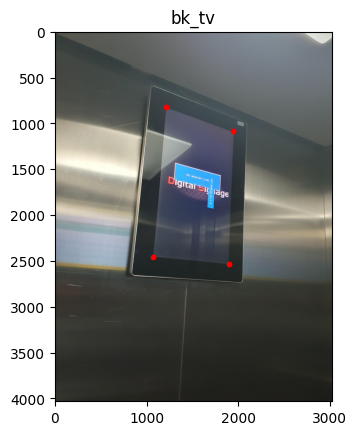

In [ ]:
place_poited_img_tv = [(820, 1210), (2460, 1070), (2530, 1900), (1080, 1940)]

plot_image_pointed(
    img=img_list[1],
    img_name='bk_tv',
    points=place_poited_img_tv,
    size=10
)

In [ ]:
tv_with_poster = warp_and_combine(
    img_list[2],
    img_list[1],
    place_poited_img_tv
)

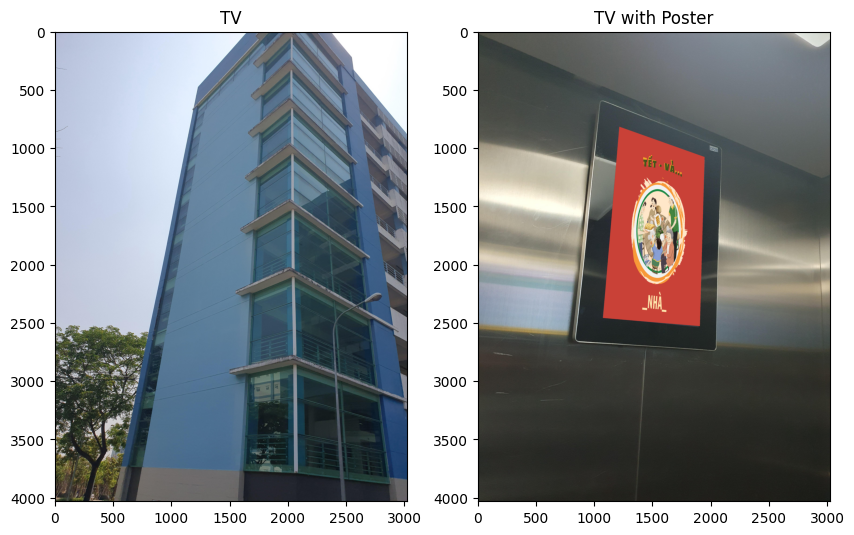

In [ ]:
print_two_images(img_list[1], tv_with_poster, "TV", "TV with Poster")

### 1.2. Try with bk h6

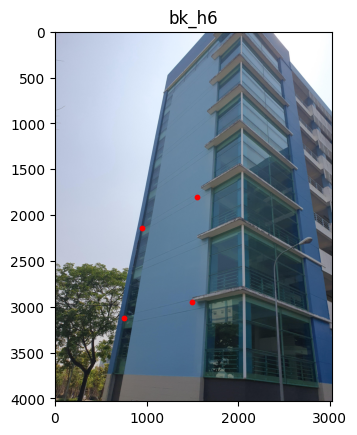

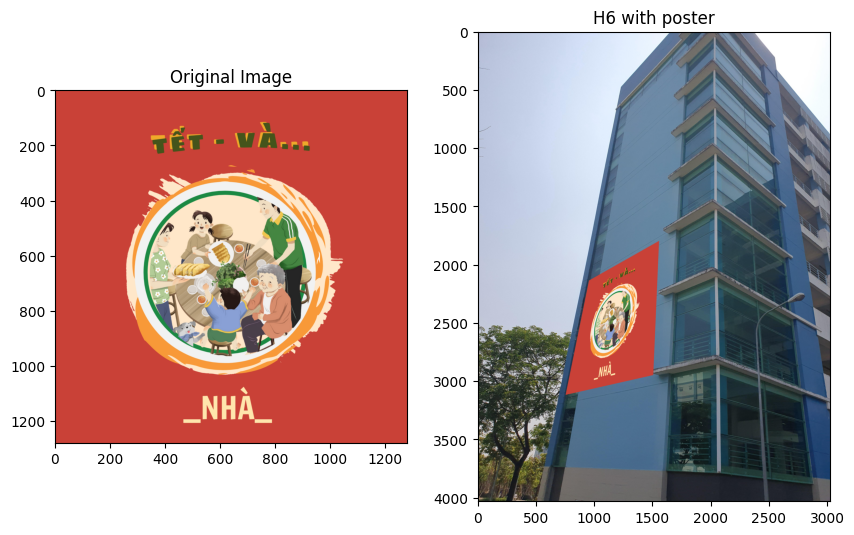

In [ ]:
place_poited_img_h6 = [(2140, 950), (3120, 750), (2950, 1500), (1800, 1550)]
plot_image_pointed(
    img=img_list[0],
    img_name='bk_h6',
    points=place_poited_img_h6,
    size=10
)

transform_img = warp_and_combine(
    img_list[2],
    img_list[0],
    place_poited_img_h6
)
print_two_images(img_list[0], transform_img, "H6", "H6 with poster")